# Barclays Premier League Fantasy Football Data Analysis

## Introduction

I've been really into BPL Fantasy Football this season and have been building a fantasy team since the start of the season last year. 

I'm not very good at picking the right squad based on my instincts, so my basic goal is to use the data from the present and past weeks to determine the best picks for the upcoming week.

## How Fantasy Football Works

I play Fantasy Football off the <a href='http://fantasy.premierleague.com'> official BPL Fantasy site</a>. For the uninitiated, Fantasy Football is an online game where users pick a squad of 15 real-life football players from a league. In this case, I'm playing the BPL, which is the English top division. Points are scored and collated depending on a player's actions in the actual game. The aim of the game is to amass the highest number of points each game week. The rules are <a href='http://fantasy.premierleague.com/rules/'> here</a>. 

In general, players will register points for scoring goals, notching assists, clean sheets, penalties. They will lose points for getting yellow cards, red cards, missing penalties and conceding goals. 

Friends tend to form mini-competitions to see who's better at picking the best squad week after week. At the end of the season, the winner of their league with the higest points gets the honour of having the best fantasy football instincts (although there's usually money involved in mini-leagues amongst friends). There's a budget allocated to each user so you can't always choose the best player because he might be too expensive. Players get transferred in and out of teams weekly, so there's an entire transfer market as well. 

## My Objective

The aim of my analysis is to predict a team of 15 players who will score the highest fantasy points within a budget of £100m in the upcoming gameweek

## Fantasy Football Data

Data is available from an API from the official site on players' basic information, team information, fixture information and performance stats. Each player's performance is aggregated every gameweek to give an overall view of the players' performance. There are nested data sets on each player's weekly performance history, as well as performance in past seasons.

The dataset contains a database of 550 players that are distributed amongst 20 teams in the BPL. There are a total of 63 data attributes for any single player. Each player has a unique player id, and data is updated once every <i>gameweek</i>. That is to say, a full round of fixtures played amongst 20 teams. Fixtures sometimes get postponed from one gameweek to another, so I'm only focusing on gameweeks with the full 10 games being played.

In essence, the gameweek view reflects the player's (a) cumulative performance up to that gameweek and (b) the player's performance in that particular gameweek. 

Above that, there are some <b>nested</b> attributes that give us a whole lot more information.

The dataset contains the "fixture history" of a player, ie. the performance of each and every player in each and every game he has played so far. This is an <i>t</i> by 20 dataframe, where *t* is the gameweek number. I will be tapping on the fixture history of each individual player to construct features about their form.

Given the wide number of features available, I'm not going to describe every single one of them. Nonetheless, here's a brief overview of the more important variables that are available in the data set:

- <b>Personal Attributes</b>
    - Player ID - Unique Identifier
    - First Name, Last name
    - Position, ie. Goalkeeper, Midfielder
- <b>Team Attributes</b>
    - Team name, Team ID
- <b>Real Life Performance Attributes</b> (measured up to current gameweek)
    - Total Goals scored
    - Assists
    - Goals Conceded
    - Total minutes played
- <b>Fantasy Performance Attributes</b> 
    - Total points scored
    - Points per game
    - Total Bonus points
    - Number of points scored in the most recent gameweek
    - Number of Bonus points scored in the most recent gameweek

[<i>These characterise the fantasy points, measured up to current gameweek, that each player has scored according to the fantasy system, and not in "real life". Bonus points are tallied in a separate system, where more "minor actions" in a game, such as a shot on target, a tackle or a clearance can be tallied. These do not directly contribute towards fantasy points.</i>]
 
- <b> Transfer Market Attributes</b>
    - Total Transfers In
    - Total Transfers Out
- <b> Injury Attributes </b>
    - % Chance of playing in this round
    - % Chance of playing in the next round
    
    

### Model Specification & Feature Selection

I conducted some preliminary modelling with a sample data set from Gameweek 26. The main purpose of my analysis was to uncover a base model specification and select a set of features for my model. 

I came to the following main conclusions in my preliminary analysis.

1. **Form matters more than cumulative performance ** 
    - Based on regression that I ran on Gameweek 26 data, I inferred that features on cumulative performance are not as significant as "form" variables. These measure the streakiness of a players' performance.
    - However, defining a form variable is tricky and highly arbitrary. I'm going to have to restrict myself to certain specification of "form" for a start.
2. **Individual performance matters more than team performance**
    - I found that team performance variables, like team form, or whether a team is playing home or away is not as significant a feature as individual performance variables

I will specify the model generally as a classification problem. My outcome variable $Y_t$ is a binary variable which is 1 if a player scores more than *r* points in the *t-th* gameweek; 0 otherwise. 
$$ Y_t =
\begin{cases}
1 & fantasypoints_t \ge r\\
0 & fantasypoints_t < r
\end{cases} $$

I will only consider features of lag 1 for a start. This means that I am assuming that a player's performance in gameweek *t-1* is relevant to his performance in gameweek *t*. As a basic model, the logistic regression model is specified as such

$$ log\frac{P(Y_{t,i}=1|\mathbf{X_{t-1,i}})}{1-P(Y_{t,i}=1|\mathbf{X_{t-1,i}})} = \beta^T.\mathbf{X_{t-1,i}} + \epsilon_i$$

for i = 1,...,550 and $ \epsilon_i \sim N(0,\sigma^2) $



### Approach

The general approach to predicting my set of 15 players for the next gameweek would thus be as follows:

1. Use the model to predict a set of top performing players for the *t-1th* gameweek, defined as players who would satisfy $Y_{t+1} =1$ and where *r* is arbitrarily defined.
2. Obtain *m* players . If *m* <15, decrease r and perform step 1 again.
3. Narrow down to 15 players using linear optimisation, with the objective of filling 15 positions subject to the constraints that there has to be 2 goalkeepers, 5 defenders, 5 midfielders and 3 forwards, and all must be fit to play in the *t+1-th* gameweek.

These are the main features in my dataset

Attributes|Type|Description
-|-|-
id|int|Unique Player ID
first_name|str| Player's First Name
second_name|str| Player's Second Name
team_name|str| Team which player belongs to
team_id|int| Unique ID number of the team that the player belongs to
type_name|str| Categorical. Whether the player is a Goalkeeper, Defender, Midfielder or Forward
now_cost|int| Cost of player in £100,000 in the *t-th* gameweek
cost_t1|int| Cost of player in £100,000 in the *t-1th* gameweek
chance_of_playing_next_round|float| Percentage likelihood that the player will play in the *t+1th* gameweek
chance_of_playing_this_round|float| Percentage likelihood that the player will play in the *tth* gameweek
minutes|int| Total number of minutes played up to the *t-th* gameweek
form|float64| A player's form, as calculated by BPL over the last 30 days in the latest gameweek. 
bonus_form_t1|int| The sum of a player's bonus points for the *t-6th* to the *t-1th* gameweek
fantasy_form_t1|int| The sum of a player's fantasy points for the *t-6th* to the *t-1th* gameweek
own_team_form|int| Total number of points that the player's team has garnered from the *t-6th* to the *t-1th* gameweek
home|boolean| Whether the *t-th* game will be played at the player's team home stadium
next_team_t|str| The name of the team that the player is up against in the *t-th* week
next_team_pos|int| The league position of the team that that the player is up against in the *t-th* week

I'll be focusing on the bottom 6 features for my model. 

In [385]:
required_fields=['id','first_name','second_name','team_name','team_id','type_name','now_cost','chance_of_playing_next_round','chance_of_playing_this_round','minutes','form']
print (len(required_fields))
full_fields = ['id','first_name','second_name','team_name','team_id','type_name','now_cost','chance_of_playing_next_round','chance_of_playing_this_round','minutes','form','bonus_form_t1','fantasy_form_t1','cost_t1','minutes_t1','goals_t1','assists_t1','clean_sheets_t1','goals_conceded_t1','saves_t1','bonus_per_min_t1', 'pts_per_min_t1','goals_per_min_t1', 'assists_per_min_t1', 'clean_sheets_per_min_t1','goals_conceded_per_min_t1','saves_per_min_t1','own_team_form','own_team_pos_t','home','next_team','next_team_pos_t','fantasy_points_t']
print (len(full_fields))

11
33


In [251]:
import re 
import requests as rq
import csv 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import numpy as np

In [35]:
###


In [6]:
import json



AttributeError: 'list' object has no attribute 'keys'

In [11]:
d = []
for i in range(1,551):
    r = rq.get('http://fantasy.premierleague.com/web/api/elements/%d' %(i)) ## Pulls data from the api ##
    R = r.json()
    d.append(R)
with open('data.json', 'w') as fp:
    json.dump(d, fp)

In [296]:
with open("data.json") as json_file:
    json_data = json.load(json_file)
    

In [279]:
team_codes = [ json_data[i]['team_code'] for i in range(len(json_data))] 


set

In [379]:
TeamPositions= {}
TeamIndex=[1,3,4,6,7,8,11,13,14,20,21,31,35,43,45,56,57,80,91,110]
for i in TeamIndex:
    d=rq.get('http://www.premierleague.com/ajax/league-table/date-timeline/expanded/2015-2016/28-02-2016/%d/CLUB.json' %(i))
    D=d.json()
    TeamPos = [d['Pos'] for d in D['clubDetails']['performance']]
    TeamName = D['clubDetails']['playersToWatch']['byRatingType']['EA_SPORTS_PLAYER_PERFORMANCE_INDEX'][0]['club']['clubCode']
    TeamPositions[TeamName]=TeamPos
    


In [380]:
teamids=(np.unique([json_data[i]['team_name'] for i in range(len(json_data))])).tolist()
teamids[12:17] = [u'Southampton',u'Sunderland',u'Stoke',u'Swansea',u'Spurs']

TeamPositions


{u'ARS': [20,
  11,
  9,
  5,
  3,
  5,
  4,
  2,
  2,
  1,
  2,
  2,
  4,
  4,
  2,
  1,
  2,
  2,
  1,
  1,
  1,
  1,
  3,
  4,
  3,
  3,
  3],
 u'AVL': [3,
  7,
  12,
  12,
  15,
  17,
  18,
  18,
  18,
  19,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20],
 u'BOU': [17,
  19,
  10,
  11,
  15,
  11,
  16,
  15,
  17,
  17,
  17,
  18,
  18,
  18,
  17,
  14,
  14,
  14,
  16,
  15,
  16,
  15,
  15,
  15,
  15,
  15,
  15],
 u'CHE': [5,
  16,
  9,
  13,
  16,
  13,
  15,
  16,
  11,
  15,
  15,
  16,
  15,
  14,
  14,
  16,
  15,
  15,
  14,
  14,
  14,
  14,
  13,
  13,
  13,
  12,
  11],
 u'CRY': [2,
  6,
  4,
  2,
  4,
  8,
  6,
  3,
  6,
  6,
  8,
  8,
  10,
  6,
  6,
  6,
  6,
  5,
  5,
  7,
  7,
  8,
  11,
  11,
  12,
  13,
  14],
 u'EVE': [6,
  3,
  7,
  9,
  5,
  6,
  5,
  7,
  9,
  10,
  9,
  8,
  7,
  7,
  9,
  9,
  10,
  9,
  11,
  11,
  11,
  11,
  12,
  11,
  8,
  10],
 u'LEI': [1,
  1,
  1,
  3,
  2,
  3,
  6,
  4,

In [373]:
tkeys = sorted(TeamPositions.keys())
team_map={teamids[i]:tkeys[i] for i in range(len(tkeys))}

team_map['Stoke']=u'STK'
team_map['Sunderland']=u'SUN'


{u'Arsenal': u'ARS',
 u'Aston Villa': u'AVL',
 u'Bournemouth': u'BOU',
 u'Chelsea': u'CHE',
 u'Crystal Palace': u'CRY',
 u'Everton': u'EVE',
 u'Leicester': u'LEI',
 u'Liverpool': u'LIV',
 u'Man City': u'MCI',
 u'Man Utd': u'MUN',
 u'Newcastle': u'NEW',
 u'Norwich': u'NOR',
 u'Southampton': u'SOU',
 u'Spurs': u'TOT',
 u'Stoke': u'STK',
 u'Sunderland': u'SUN',
 u'Swansea': u'SWA',
 u'Watford': u'WAT',
 u'West Brom': u'WBA',
 u'West Ham': u'WHU'}

In [381]:
TeamPositions[team_map[json_data[1]['team_name']]]

4

In [21]:
import time
t0=time.time()

In [390]:
## This is the code I used to extract and compile 20 weeks worth of gameweek data in the csv files that I have pushed to my project folder in the git
data=json_data
def generate_gw_data(gw,lag,json_data):
    data=[]
    t_form=[]
    for i in range(0,549):
        p_data = [json_data[i][required_fields[j]] for j in range(len(required_fields))] ## These "required fields" are the player id, name, team name etc. ##
        p_hist = json_data[i]['fixture_history']['all'] ## This contains the fixture history of the i-th player amongst 550 players.##
        
        ## Form variables are the sum of points from gw-1th to the (gw-1-lag)th gameweek. These are individual performance attributes## 
        
        bonus_form_t1 = float(sum([p_hist[j][16] for j in range((gw-1-lag),(gw-1))]))
        fantasy_form_t1 = float(sum([p_hist[j][19] for j in range((gw-1-lag),(gw-1))]))  
        minutes_t1 = float(sum([p_hist[j][3] for j in range((gw-1-lag),(gw-1))]))
        goals_t1 = float(sum([p_hist[j][4] for j in range((gw-1-lag),(gw-1))]))
        assists_t1 = float(sum([p_hist[j][5] for j in range((gw-1-lag),(gw-1))]))
        clean_sheets_t1 = float(sum([p_hist[j][6] for j in range((gw-1-lag),(gw-1))]))
        goals_conceded_t1 = float(sum([p_hist[j][7] for j in range((gw-1-lag),(gw-1))]))
        saves_t1= float(sum([p_hist[j][13] for j in range((gw-1-lag),(gw-1))]))
        cost_t1 = p_hist[gw-1][18]

        ## Per minute features##
        
        if minutes_t1>0:
            bonus_per_min_t1 = bonus_form_t1/minutes_t1
            pts_per_min_t1 = fantasy_form_t1/minutes_t1
            goals_per_min_t1 = goals_t1/minutes_t1
            assists_per_min_t1 = assists_t1/minutes_t1
            clean_sheets_per_min_t1 = clean_sheets_t1/minutes_t1
            goals_conceded_per_min_t1 = goals_conceded_per_min_t1/minutes_t1
            saves_per_min_t1=saves_t1/minutes_t1
        else:
            bonus_per_min_t1 = pts_per_min_t1 = goals_per_min_t1 = assists_per_min_t1 = clean_sheets_per_min_t1 = goals_conceded_per_min_t1 = saves_per_min_t1= 0
        
        ## Team Performance Attributes ##
        teamkeys
        for j in range((gw-1-lag),(gw-1)):
            g= re.match("(.*)(...) ([0-9]+)?-?([0-9]+)",p_hist[j][2])
            if g.groups()[2]==g.groups()[3]:
                result=1
            elif g.groups()[2]>g.groups()[3]:
                result = 3
            elif g.group()[2]<g.groups()[3]:
                result =0
        t_form.append(result)
        own_team_form=sum(t_form) # use regex to derive the "team form" feature#
        own_team_pos_t= TeamPositions[team_map[json_data[i]['team_name']]][gw]
        next_team=json_data[i]['fixture_history']['all'][gw][2].split()[0][0:3]
        next_team_pos_t= TeamPositions[next_team][gw]
        t_form=[]
        home = re.match("(.*)(...) ([0-9]+)?-?([0-9]+)",p_hist[gw][2]).groups()[1] == '(H)'
                
        ## Outcome variable ## 
        
        fantasy_points_t=d[i]['fixture_history']['all'][gw][19] 
        
        p_data.extend([bonus_form_t1,fantasy_form_t1,cost_t1,minutes_t1,goals_t1,assists_t1,clean_sheets_t1,goals_conceded_t1,saves_t1,bonus_per_min_t1, pts_per_min_t1,goals_per_min_t1, assists_per_min_t1, clean_sheets_per_min_t1,goals_conceded_per_min_t1,saves_per_min_t1,own_team_form,own_team_pos_t,home,next_team,next_team_pos_t,fantasy_points_t])
        data.append(p_data)
        
    df = pd.DataFrame(data=data,columns=full_fields) # convert to pandas dataframe
    return df

    df.to_csv('Fantasy Gameweek %d.csv' %(gw), encoding = 'utf') # Writes the csv


In [392]:
GW6= generate_gw_data(6,3,json_data)
GW7= generate_gw_data(7,3,json_data)

In [393]:
## Top 10 players for GW26

GW6.sort_values(by='fantasy_points_t',ascending=False).head(10)

,id,first_name,second_name,team_name,team_id,type_name,now_cost,chance_of_playing_next_round,chance_of_playing_this_round,minutes,...,assists_per_min_t1,clean_sheets_per_min_t1,goals_conceded_per_min_t1,saves_per_min_t1,own_team_form,own_team_pos_t,home,next_team,next_team_pos_t,fantasy_points_t
12,13,Alexis,Sánchez,Arsenal,1,Midfielder,109,100,100,1650,...,0.000000,0.011407,0,0,3,4,False,LEI,6,20
148,149,Romelu,Lukaku,Everton,6,Forward,88,100,100,2419,...,0.000000,0.004032,0,0,3,5,False,WBA,15,16
237,238,Juan,Mata,Man Utd,10,Midfielder,81,NaN,NaN,2168,...,0.004484,0.008969,0,0,3,1,True,SUN,20,14
198,199,Daniel,Sturridge,Liverpool,8,Forward,99,100,100,352,...,0.000000,0.000000,0,0,1,7,True,AVL,18,13
530,531,Rudy,Gestede,Aston Villa,2,Forward,55,100,100,1223,...,0.000000,0.000000,0,0,1,18,False,LIV,7,13
339,340,Erik,Lamela,Spurs,14,Midfielder,68,100,100,1688,...,0.011364,0.011364,0,0,3,5,True,MCI,2,12
272,273,Ayoze,Pérez Gutiérrez,Newcastle,11,Forward,51,NaN,NaN,1589,...,0.000000,0.007874,0,0,1,19,True,CHE,15,12
169,170,Jamie,Vardy,Leicester,7,Forward,78,100,100,2538,...,0.003704,0.000000,0,0,3,6,True,ARS,4,12
312,313,Dusan,Tadic,Southampton,13,Midfielder,66,NaN,NaN,1611,...,0.000000,0.011111,0,0,1,9,True,SWA,11,11
364,365,Jonathan,Walters,Stoke,15,Midfielder,56,100,100,1486,...,0.000000,0.000000,0,0,1,17,True,BOU,16,10


In [394]:
##Drop redundant players who have played 0 minutes up to GW 6. 

gw6=GW6[GW6.minutes!=0]
gw6_def=gw6[gw6.type_name=="Defender"]
gw6_mf=gw6[gw6.type_name=="Midfielder"]
gw6_fwd=gw6[gw6.type_name=="Forward"]
gw6_gk=gw6[gw6.type_name=="Goalkeeper"]

In [93]:
## Let's try some classifiers...

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

In [256]:
## This is my binary variable, with r = 5
gw6_fwd['points_scorer'] = gw6_fwd.fantasy_points_t>5
gw6_fwd['points_scorer'] = gw6_fwd.points_scorer.astype(int)

X_fwd_t= gw6_fwd[['bonus_form_t1','fantasy_form_t1','own_team_form', 'home', 'next_team_pos_t','minutes_t1','goals_t1','assists_t1','bonus_per_min_t1','pts_per_min_t1','goals_per_min_t1','assists_per_min_t1']]
y_fwd_t= gw6_fwd.fantasy_points_t
type(gw6_fwd.points_scorer)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


pandas.core.series.Series

(array([ 0.390625  ,  0.10416667,  0.02604167,  0.01736111,  0.01736111,
         0.02604167,  0.        ,  0.01736111,  0.01736111,  0.00868056]),
 array([  0. ,   1.6,   3.2,   4.8,   6.4,   8. ,   9.6,  11.2,  12.8,
         14.4,  16. ]),
 <a list of 10 Patch objects>)

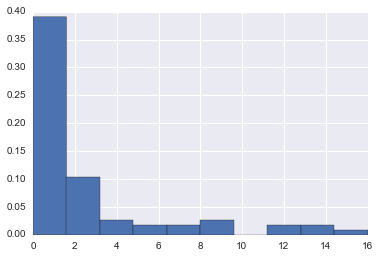

In [260]:
plt.hist(np.asarray(gw6_fwd.fantasy_points_t),normed=True)

In [172]:
r = preprocessing.scale(X_fwd_t)
type(np.array(X_fwd_t))

numpy.ndarray

In [224]:
## I'm going to use Gameweek 7 data as test set

GW7 = pd.read_csv('Fantasy Gameweek 7.csv')
gw7 = GW7[GW7.minutes!=0]
gw7_fwd=gw7[gw7.type_name=="Forward"]

gw7_fwd['points_scorer'] = gw7_fwd.fantasy_points_t>5
gw7_fwd['points_scorer'] = gw7_fwd.points_scorer.astype(int)
print sum(gw7_fwd['points_scorer'])
# Create new feature set and define new binary outcome variable

X_fwd_t1= gw7_fwd[['bonus_form_t1','fantasy_form_t1','own_team_form', 'home', 'next_team_pos_t','minutes_t1','goals_t1','assists_t1','bonus_per_min_t1','pts_per_min_t1','goals_per_min_t1','assists_per_min_t1']]
y_fwd_t1= gw7_fwd.fantasy_points_t

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


8


In [84]:
# Recycling a function from the lab

def accuracy_report(clf,xtrain,ytrain,xtest,ytest):
    print "Accuracy: %0.2f%%" % (100 * clf.score(xtest, ytest))

    #Print the accuracy on the test and training dataset
    training_accuracy = clf.score(xtrain, ytrain)
    test_accuracy = clf.score(xtest, ytest)

    print "Accuracy on training data: %0.2f" % (training_accuracy)

In [161]:
## Try some classifiers.. 
clf_bn=BernoulliNB().fit(X_fwd_t,y_fwd_t)
print "Fit Accuracy for Binomial Naive Bayes"
accuracy_report(clf_bn,X_fwd_t,y_fwd_t,X_fwd_t1,y_fwd_t1)

clf_gauss = GaussianNB().fit(X_fwd_t,y_fwd_t)
print "Fit Accuracy for Gaussian Naive Bayes"
accuracy_report(clf_gauss,X_fwd_t,y_fwd_t,X_fwd_t1,y_fwd_t1)

clf_log=LogisticRegression().fit(X_fwd_t,y_fwd_t)
print "Fit Accuracy for Logistic Regression"
accuracy_report(clf_log,X_fwd_t,y_fwd_t,X_fwd_t1,y_fwd_t1)

rbf_svm=SVC(kernel='rbf').fit(X_fwd_t,y_fwd_t)
print "Fit Accuracy for RBF SVM"
accuracy_report(rbf_svm,X_fwd_t,y_fwd_t,X_fwd_t1,y_fwd_t1)

lin_svm=LinearSVC().fit(X_fwd_t,y_fwd_t)
print "Fit Accuracy for Linear SVM"
accuracy_report(lin_svm,X_fwd_t,y_fwd_t,X_fwd_t1,y_fwd_t1)

Fit Accuracy for Binomial Naive Bayes
Accuracy: 47.22%
Accuracy on training data: 0.79
Fit Accuracy for Gaussian Naive Bayes
Accuracy: 29.17%
Accuracy on training data: 0.46
Fit Accuracy for Logistic Regression
Accuracy: 45.83%
Accuracy on training data: 0.82
Fit Accuracy for RBF SVM
Accuracy: 47.22%
Accuracy on training data: 0.99
Fit Accuracy for Linear SVM
Accuracy: 47.22%
Accuracy on training data: 0.85


In [100]:


## My classifier isn't actually predicting true positives for Y_t > 5! It's basically just predicting most players are scoring below than 5.

[[13 51]
 [ 0  8]] [[15 49]
 [ 0  8]] [[64  0]
 [ 8  0]]


In [101]:
confusion_matrix(y_fwd_t1,clf_log.predict(X_fwd_t1))



array([[13, 51],
       [ 0,  8]])

In [249]:
confusion_matrix(y_fwd_t1,rbf_svm.predict(X_fwd_t1))

array([[34,  0,  0,  0,  0,  0,  0,  0,  0],
       [17,  0,  0,  0,  0,  0,  0,  0,  0],
       [12,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0]])

In [162]:
confusion_matrix(y_fwd_t1,lin_svm.predict(X_fwd_t1))

array([[34,  0,  0,  0,  0,  0,  0,  0,  0],
       [17,  0,  0,  0,  0,  0,  0,  0,  0],
       [12,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0]])

In [105]:
lin_svm.predict(X_fwd_t1)

array([1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1])

In [190]:
import statsmodels.formula.api as sm

In [236]:
type(X_fwd_t)

pandas.core.frame.DataFrame

In [193]:
lin=sm.ols(formula= "fantasy_points_t ~ bonus_form_t1 + fantasy_form_t1 + own_team_form + home + next_team_pos_t + minutes_t1 + goals_t1 + assists_t1 + bonus_per_min_t1 + pts_per_min_t1 + goals_per_min_t1 + assists_per_min_t1" ,data=gw6_fwd)
gw6_fit=lin.fit()
gw6_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       fantasy_points_t   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     1.585
Date:                Tue, 08 Mar 2016   Prob (F-statistic):              0.121
Time:                        23:28:52   Log-Likelihood:                -185.67
No. Observations:                  72   AIC:                             397.3
Df Residuals:                      59   BIC:                             426.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              0.3277      1.667      0.197      0.845        -3.009     3.664
home[T.True]           0.8619      0.907      0.951      0.346        -0.953     2.676
bonus_form_t1          0.0264      0.136      0.194      0.847        -0.246     0.299
fantasy_form_t1        0.1220      0.695      0.176      0.861        -1.268     1.512
own_team_form         -0.1373      0.464     -0.296      0.768        -1.065     0.790
next_team_pos_t        0.0317      0.077      0.413      0.681        -0.122     0.186
minutes_t1             0.0149      0.015      0.994      0.324        -0.015     0.045
goals_t1              -2.2502      3.267     -0.689      0.494        -8.786     4.286
assists_t1             2.9339      4.465      0.657      0.514        -6.000    11.867
bonus_per_min_t1       2.1696     13.867      0.156      0.876       -25.579    29.918
pts_per_min_t1        -2.8573     27.959     -0.102      0.919       -58.802    53.088
goals_per_min_t1     -42.9684    206.418     -0.208      0.836      -456.009   370.072
assists_per_min_t1  -848.8653    763.699     -1.112      0.271     -2377.024   679.294
==============================================================================
Omnibus:                       34.394   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.073
Skew:                           1.688   Prob(JB):                     3.69e-16
Kurtosis:                       6.507   Cond. No.                     2.55e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.55e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [248]:
gw6_fwd['gw7_predictions']=gw6_fit.predict(X_fwd_t)
ind=gw6_fwd.gw7_predictions.loc(gw6_fwd.gw7_predictions>5)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


KeyError: <pandas.core.indexing._LocIndexer object at 0x10f5a5ed0>

In [141]:
gw6_fwd.second_name[ind]

50            Benteke
73             Wilson
97     Da Silva Costa
148            Lukaku
150              Koné
169             Vardy
221            Agüero
292            Jerome
349              Kane
391             Defoe
416             Gomis
440            Deeney
484             Sakho
Name: second_name, dtype: object